This NCL script will download 30+ years of monthly temperature data and present the data in a spiral plot. 

Some of the generic plotting functions are included in a seperate file.  These functions are available in this repo and on the NCL examples pages. 

Created by Alan Brammer, based on a request on ncl-talk with regard to plots found here:  http://www.climate-lab-book.ac.uk/2016/spiralling-global-temperatures/

In [1]:
load "./radial_plot_functions.ncl"
load "$NCARG_ROOT/lib/ncarg/nclscripts/contrib/cd_string.ncl"

The above script contains functions laid out similar to the below.  These can be generic functions that we can use over and over to make the bulk of our scripts simpler. 

In [2]:
undef("add_colored_line")
procedure add_colored_line( wks, map, Y, X, Z, levels, colors, gsres)
local nmi, y, x, value, newx, newy, newval, lres, cmap
begin
;; We're going to skip over missing points, e.g. linear interpoye over them
;; This might not be desired.
nmi = ind( (.not. ismissing(Y)) .and. (.not. ismissing(X)) .and. (.not. ismissing(Z)) )
x =  X(nmi)
y = Y(nmi)
value = Z(nmi)


if(isnumeric(colors))
    cmap = colors
else
    cmap = read_colormap_file(colors)
end if

;  Get color for each value along line
icolors = new(dimsizes(value), integer)
do i=0, dimsizes(icolors)-1
  icolors(i) = get_color_index( cmap, levels, value(i) )   ;; there should really be a get_color_indexes()
end do

;; Use the new gsSegments to color each segment individual
;; Need to do some trickery with the array for gsSegments to work

newx = new(dimsizes(x)*2, typeof(x))
newx(::2) = x
newx(1::2) = x

newy = new(dimsizes(y)*2, typeof(y))
newy(::2) = y
newy(1::2) = y

newval = new(dimsizes(value)*2, typeof(value))
newval(::2) = value
newval(1::2) = value

new_icolors = new(dimsizes(icolors)*2, typeof(icolors))
new_icolors(::2) = icolors
new_icolors(1::2) = icolors


lres = True
lres@gsLineThicknessF = get_res_value(gsres,"gsLineThicknessF", 2.)
lres@gsSegments = ispan(1, dimsizes(newy)-2,2)
lres@gsColors = cmap(new_icolors,:)
copy_VarAtts(gsres, lres)
print(lres)

;; add to plot as attribute, unqiue_string() is really slow so add as numbered att instead.
cts = str_sub_str(str_match(getvaratts(map),"c_line"),"c_line","" )
if(all(ismissing(cts)))
    ct = 0
else
    ct = max(toint(cts))+1
end if

map@$tostring("c_line"+ct)$ = gsn_add_polyline(wks, map, newx,  newy, lres)

end





###  With functions loaded, let's get started and find some data.

    NCL can use system calls, so as this is a small text dataset which is available on the internet.  Lets just download it with curl and read it straight into NCL. 
   

In [3]:
csv_data = systemfunc("curl https://data.giss.nasa.gov/gistemp/tabledata_v3/GLB.Ts+dSST.csv")
print(csv_data(:4))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12124  100 12124    0     0  15548      0 --:--:-- --:--:-- --:--:-- 15543Variable: csv_data (subsection)
Type: string
Total Size: 40 bytes
            5 values
Number of Dimensions: 1
Dimensions and sizes:	[5]
Coordinates: 
(0)	Land-Ocean: Global Means
(1)	Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
(2)	1880,-.30,-.19,-.12,-.20,-.12,-.24,-.22,-.10,-.17,-.25,-.21,-.24,-.20,***,***,-.15,-.19,-.21
(3)	1881,-.16,-.18,.03,.03,.01,-.21,-.07,-.03,-.14,-.22,-.23,-.12,-.11,-.12,-.19,.02,-.10,-.20
(4)	1882,.14,.14,.03,-.19,-.17,-.27,-.21,-.06,-.11,-.26,-.17,-.25,-.12,-.10,.05,-.11,-.18,-.18

 ### Look at your data.  

The above 5 lines from the file show us that there are 2 header lines and then 19 columns.  With column 0 == year then 13-18 == seasonal values.  
 
 Today we only care about the monthly values, so want columns 1-12 after the first 2 lines.   We also want to make this 2-d array into a single time series with the appropriate metadata. 

In [4]:
data_table := str_split_csv(csv_data(2:), ",",0)

nyears = dimsizes(csv_data)-2
monthly_data = reshape(data_table(:,1:12), (nyears*12) )
monthly_data!0="time"
monthly_data&time = fspan(0, (nyears*12)-1, (nyears*12))
monthly_data&time@units = "months since "+data_table(0,0)+"-01-01"
printVarSummary(monthly_data)

;; print every 6 month to double check everything is correct
print(cd_calendar(monthly_data&time(::6), 2))  


Variable: monthly_data
Type: string
Total Size: 13248 bytes
            1656 values
Number of Dimensions: 1
Dimensions and sizes:	[time | 1656]
Coordinates: 
            time: [ 0..1655]Variable: unnamed (return)
Type: double
Total Size: 2208 bytes
            276 values
Number of Dimensions: 1
Dimensions and sizes:	[276]
Coordinates: 
Number Of Attributes: 1
  calendar :	standard
(0)	18800101
(1)	18800701
(2)	18810101
(3)	18810701
(4)	18820101
(5)	18820701
(6)	18830101
(7)	18830701
(8)	18840101
(9)	18840701
(10)	18850101
(11)	18850701
(12)	18860101
(13)	18860701
(14)	18870101
(15)	18870701
(16)	18880101
(17)	18880701
(18)	18890101
(19)	18890701
(20)	18900101
(21)	18900701
(22)	18910101
(23)	18910701
(24)	18920101
(25)	18920701
(26)	18930101
(27)	18930701
(28)	18940101
(29)	18940701
(30)	18950101
(31)	18950701
(32)	18960101
(33)	18960701
(34)	18970101
(35)	18970701
(36)	18980101
(37)	18980701
(38)	18990101
(39)	18990701
(40)	19000101
(41)	19000701
(42)	19010101
(43)	19010701
(44)	19020

### Process data for plotting

Plotting all 137 years of data would get pretty busy so let's select the data after 1979.  We also then want convert months 1 - 12 into a 0-360 unit.  

We first define the orientation of the months, with respect to the radial plot functions.  12 oclock (top) is 90 (and 90-360), 9pm = 0 (left), 6pm = -90, 3pm = -180 
This is a little awkard because the radial plot function wants the 0 to be pointing west and rotate counterclockwise.  

We can then take the modulus of the date with respect to 12 to get a 1-12 unit for each value in the timeseries and convert that to our 90 to -240 scale.  
We could easily do this with an equation, but selecting indices means we can change out months scale with out working out new conversion rules.  

In [5]:
stime = cd_inv_calendar(1979,1,1,0,0,0,monthly_data&time@units,0)

temp := monthly_data({stime:})
temp@_FillValue = "***"   ; always look at your data to know what secrets are hiding
printVarSummary(temp)

months =fspan(90,-240,12)-15  ;; convert 1-12 to counterclockwise radial plot, starting at top. (90)
months = where(months.lt.0, months+360., months)

dates := temp&time
angles := months(toint(dates)%12)
range  := tofloat(temp)



Variable: temp
Type: string
Total Size: 3744 bytes
            468 values
Number of Dimensions: 1
Dimensions and sizes:	[time | 468]
Coordinates: 
            time: [1188..1655]
Number Of Attributes: 1
  _FillValue :	***

In [6]:
printVarSummary(angles)
printMinMax(angles,0)
printVarSummary(range)
printMinMax(range,0)

Variable: angles
Type: float
Total Size: 1872 bytes
            468 values
Number of Dimensions: 1
Dimensions and sizes:	[468]
Coordinates: (0)	min=15   max=345Variable: range
Type: float
Total Size: 1872 bytes
            468 values
Number of Dimensions: 1
Dimensions and sizes:	[468]
Coordinates: 
Number Of Attributes: 1
  _FillValue :	9.96921e+36(0)	min=-0.11   max=1.35

### Look at your data

Have I mentioned that you should always be checking that the data matches your expectations.  

The output above should show we have a range of angles between 15 and 345 with a temperature range between around 0 to 1.4C

These 30 lines will now set up the plot resources, call the plotting routines, and then finally draw and frame the image.   NCL has many resources for plots so you can edit pretty much anything.  

Variable: cmap
Type: float
Total Size: 2048 bytes
            512 values
Number of Dimensions: 2
Dimensions and sizes:	[128] x [4]
Coordinates: 
Number Of Attributes: 1
  _FillValue :	9.96921e+36Variable: lres
Type: logical
Total Size: 4 bytes
            1 values
Number of Dimensions: 1
Dimensions and sizes:	[1]
Coordinates: 
Number Of Attributes: 3
  gsColors :	<ARRAY of 3704 elements>
  gsSegments :	<ARRAY of 462 elements>
  gsLineThicknessF :	 8
(0)	True./spiral_temperature_plot

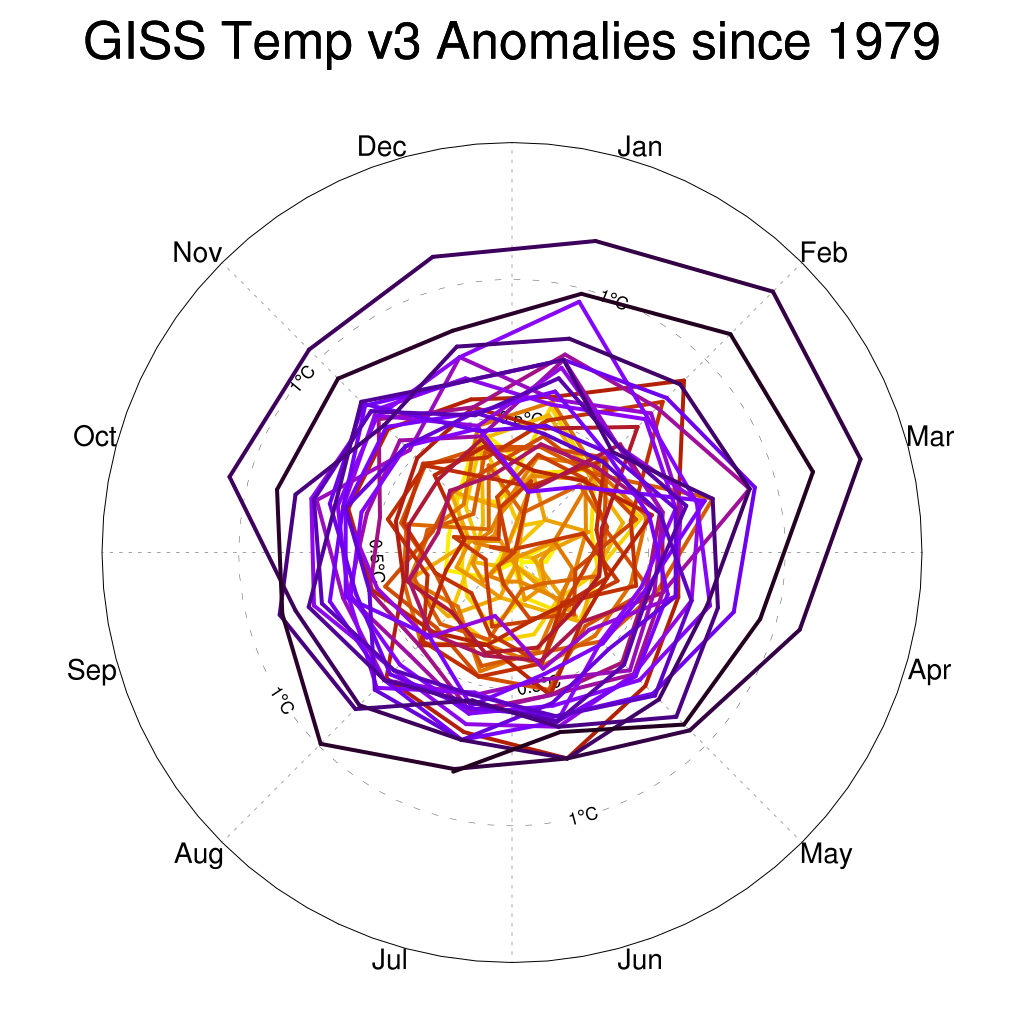

In [7]:
wks = gsn_open_wks("png","spiral_temperature_plot")

res                             := True

res@rdlRadius                   = 1.5
res@rdlRadialLineColor          = "gray32"     ; default is "foreground"
res@rdlRadialLineAngle          = 45           ; in degrees

res@rdlInnerCircleSpacing       = 0.5     ; in units of the radius
res@rdlInnerCircleLineColor     = "gray32"     ; default is "foreground"
res@rdlInnerCircleLabelUnits := "~F34~0~F~C"

res@rdlOuterLabelStrings = (/"Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"/)
res@rdlOuterLabelValues  := months
res@rdlOuterCircleLineThickness = 2            ; default is 1.0

res@tiMainString                = "GISS Temp v3 Anomalies since 1979"
cmap := read_colormap_file("MPL_gnuplot")
cmap= cmap(::-1,:)
printVarSummary(cmap)
levels := dates(::6)  ;; used to colour the line later. 


gs = True
gs@gsLineThicknessF = 8.

plot = radial_plot(wks, res)
locs := convert_to_radial_plot(range, angles, res)
add_colored_line(wks, plot, locs(1,:), locs(0,:), dates, levels, cmap, gs)

draw(plot)
frame(wks)

So we have the basic premise for the plot.  We could now run this through a loop and make an animation out of the stills (NCL can't make animations directly; I don't know how to display animations in jupyter either), or other fun things. 

 Have fun.   Any comments or questions, head to the github repo.  